# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [26]:
from utils import get_module_logger
from utils import get_dataset
from os import listdir
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import logging
%matplotlib inline

In [27]:
# logging.basicConfig(filename = 'errors.log', level = logging.WARNING)
logger = get_module_logger(__name__)
tf.compat.v1.logging.set_verbosity(30)

In [28]:
files = listdir("data/train")
file = random.choice(files)
dataset = get_dataset("data/train/" + file)

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [29]:
def display_instances(batch, row, col, ax):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """  
       
    image = tf.cast(batch['image']/255, tf.float32)  
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    
    
    bboxes = batch['groundtruth_boxes'].numpy()
    classes = batch['groundtruth_classes'].numpy()
    
    # vehicles in red [1,0,0]
    # pedestrians in blue [0,1,0]
    # cyclists in green [0,0,1]
    colormap = {1: [1,0,0], 2: [0,0,1], 4:[0,1,0]}
    for box, cls in zip(bboxes, classes):
        y1, x1, y2, x2 = box
        y1 = y1 * 640
        x1 = x1 * 640
        y2 = y2 * 640
        x2 = x2 * 640
        rec = Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor = 'none', edgecolor = colormap[cls])
        ax[row, col].add_patch(rec)                  

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

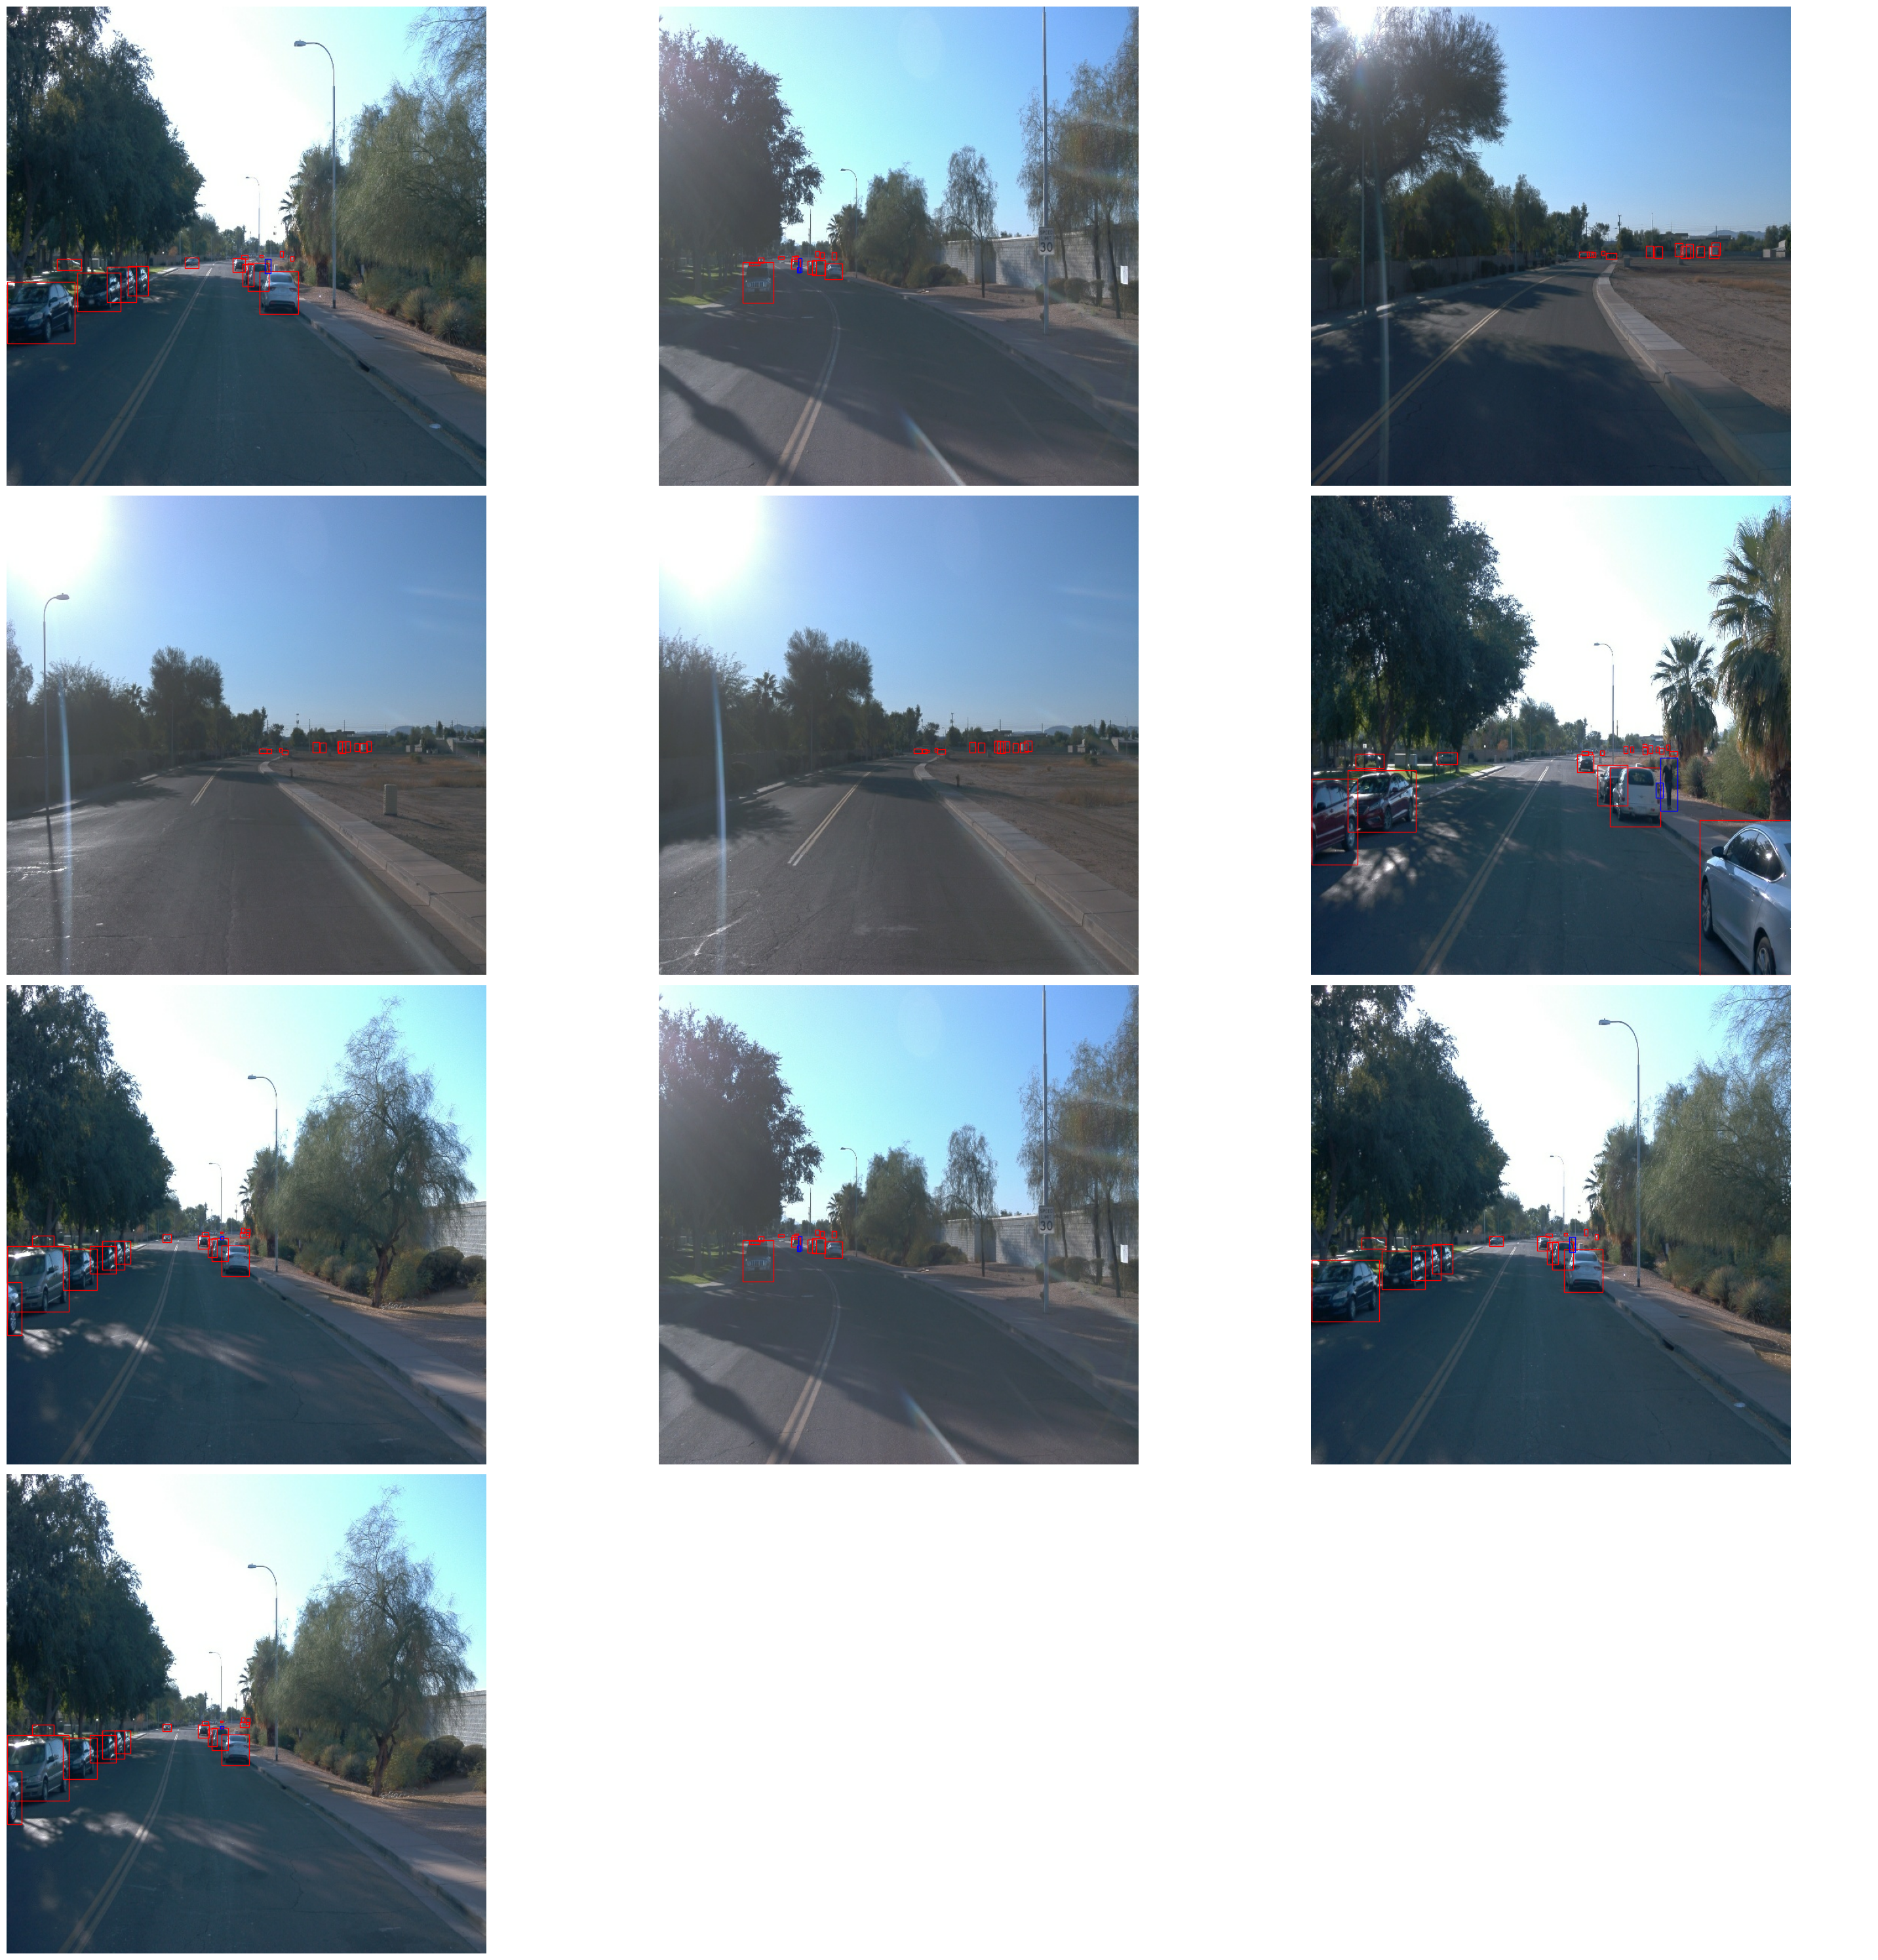

In [30]:
dataset = dataset.shuffle(buffer_size = 1000)
fig, ax = plt.subplots(4, 3, figsize = (30, 30))
row = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3]
for idx in range(10):
    for batch in dataset.take(1):
        display_instances(batch, row[idx], idx%3, ax)
ax[3, 1].axis('off')
ax[3, 2].axis('off')
fig.tight_layout()

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [31]:
class_values = []
stats = np.zeros((len(files[:3]), 8))

# Iterate through all files
# for idx, file in enumerate(files):
for idx, file in enumerate(files[:3]):
    print(idx)
    dataset = get_dataset('data/train/' + file)
    images = 0
    vehicles = 0
    pedestrians = 0
    cyclists = 0
    # Iterate through each image 
    for idj, batch in enumerate(dataset.take(640)):
        images += 1
        classes = batch['groundtruth_classes'].numpy()
        # Count the number of objects of each type
        vehicles += np.count_nonzero(classes == 1)
        pedestrians += np.count_nonzero(classes == 2)
        cyclists += np.count_nonzero(classes == 4)
        for element in classes:
            if element not in class_values:
                class_values.append(element)
    # Store the total number of objects of each type across all images in a file
    total = vehicles + pedestrians + cyclists
    stats[idx] = [images, total, vehicles, pedestrians, cyclists, vehicles / total, pedestrians / total, cyclists / total]

0
1
2


In [32]:
with np.printoptions(precision = 2, suppress = True):
    print(stats)

[[  640.    6848.    6848.       0.       0.       1.       0.       0.  ]
 [  640.   26437.   13873.   12467.      97.       0.52     0.47     0.  ]
 [  640.    9705.    8786.     919.       0.       0.91     0.09     0.  ]]


## Exploratory Data Analysis
1. Uniformity across images in a single file appears to be high. E.g. all images in a single file are in sunny conditions / rainy conditions / daytime / nighttime. 
2. Number of annotated objects varies a lot between the different files. 
3. The vast majority of objects are classified as "vehicle". Especially the percentage of objects classified as "cyclist" is very low.

Rather than use sets of files for training or validation or testing pruposes, content for each of those purposes should be randomly selected from each of the files. This should ensure increased uniformity across the data that is used for training, validation and testing purposes.

In [33]:
columns = 8
rows = int(np.ceil(len(files) / columns))
print(f'nu of files: {len(files)}, nr of columns: {columns}, nr of rows: {rows}')
fig, ax = plt.subplots(rows, columns, figsize = (30, 30))

row = -1
for nr, file in enumerate(files):
    dataset = get_dataset("data/train/" + file)
    for idx, batch in enumerate(dataset.take(1)):
        if idx == 0:
            column = nr % columns
            if column == 0:
                row = row + 1
            print(row, column)
            display_instances(batch, row, column, ax)

nu of files: 86, nr of columns: 8, nr of rows: 11
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2


KeyboardInterrupt: 